In [1]:
%load_ext autoreload
%autoreload 2

## Training Transformer

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.utils.class_weight import compute_class_weight


tqdm.pandas()

In [3]:
def get_first_texts(x, min_size = 15):
    size = x.apply(lambda x: len(x.split(" ")))\
        .sort_values()
    
    x = x.reindex_like(size)
    mask = size > min_size
    # mask = x.str.lower().str.contains("goal")

    # return "\n".join(x[mask])
    return x[mask].tolist()

In [4]:
train_indices = [0]
val_indices = [8,11,13]
train_data, test_data = train_test_split()

def get_samples(indices, frac = 1):
    all_df = []
    for id in indices:
        temp_df = train_data[id]
        # for i in range(1,5+1):  
        #     temp_df[f"Tweet"] = temp_df['Tweet'].shift(i) + temp_df['Tweet']
        
        all_df.append(temp_df.dropna().sample(frac=frac))

        
    return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({
        "Tweet":    get_first_texts,
        "EventType": np.mean,
        "ID": len
    })

train_df = get_samples(train_indices)
val_df = get_samples(val_indices)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
/tmp/ipykernel_1541494/1029783939.py:15: FutureWarning: The provided callable <function mean at 0x7fbc6c1d5bc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({


<Axes: xlabel='ID', ylabel='Density'>

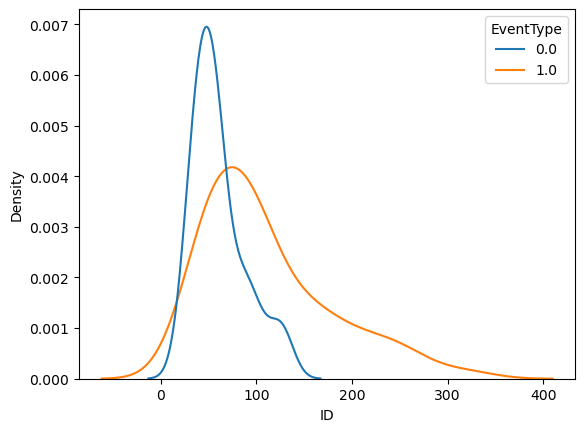

In [5]:

sns.kdeplot(train_df, x= 'ID', hue = 'EventType')

In [7]:
train_df = pd.read_csv("data/real_labels_1.csv", index_col= 0 )
train_df_2 = pd.read_csv("data/real_labels_2.csv", index_col=0)

train_df = pd.concat([train_df, train_df_2])
train_df['label'] = train_df['event'].map({
    "no": 0,
    "yes": 1,
    "penalty" : 1,
    "goal" : 1
})
val_df = train_df.iloc[7_000:]
train_df = train_df.iloc[0:1000]

In [8]:
train_df

,event,reason,MatchID,PeriodID,originalTweet,EventType,label
0,yes,Full time has been reached in both games in Gr...,2,121,#NED 2 #CHI 0 - #ESP 3 #AUS 0. Fulltime in bot...,1,1
1,no,The tweet is a general statement of support fo...,4,9,rootin for the underdogs here go #ALG,0,0
2,no,The tweet does not indicate a specific footbal...,4,74,Okay now Algeria might lose..,0,0
3,no,The tweet does not describe a specific footbal...,4,163,You did good #ALG,1,0
4,no,The tweet does not represent a specific footba...,4,144,Algeria get your shit together and make us pro...,1,0
...,...,...,...,...,...,...,...
995,no,The tweet does not describe a specific footbal...,4,106,"Damn, this Algerian goalie is in beast mode! #...",0,0
996,no,The tweet does not describe a specific footbal...,4,53,#ALG is plahing like beasts.,0,0
997,no,The tweet does not represent a football event.,4,60,Oktoberfest is months away Germany please stop...,1,0
998,no,The tweet does not describe a specific footbal...,4,162,"Algeria are a fucking sick team, they've shock...",1,0


In [13]:
class BertWithExtraFeature(torch.nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=768, extra_feature_size=1):
        super(BertWithExtraFeature, self).__init__()
        # Load the pre-trained BERT model
        self.bert = AutoModel.from_pretrained(bert_model_name, cache_dir = '/Data')
        self.hidden_size = hidden_size
        self.extra_feature_size = extra_feature_size
        
        # Fully connected layer to combine BERT output and extra feature
        self.fc = torch.nn.Linear(self.hidden_size + self.extra_feature_size, 2)
    
    def forward(self, input_ids, attention_mask, extra_feature):
        """
        Args:
            input_ids: Tensor of shape (batch_size, seq_len) with token IDs.
            attention_mask: Tensor of shape (batch_size, seq_len) for masking attention.
            extra_feature: Tensor of shape (batch_size, 1) with the additional feature.

        Returns:
            Logits for binary classification.
        """
        # Get BERT output (pooled output)
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output  # Shape: (batch_size, hidden_size)
        
        # Concatenate the pooled output with the extra feature
        combined_input = torch.cat((pooled_output, extra_feature), dim=1)  # Shape: (batch_size, hidden_size + extra_feature_size)
        
        # Pass through the fully connected layer
        logits = self.fc(combined_input)  # Shape: (batch_size, 1)
        
        return logits

In [31]:
from torch.cuda.amp import autocast
def evaluate_model(val_dataloader, model, device : str = 'cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        with torch.autocast(device_type = 'cuda'):
            for i,batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                # count = batch['count'].to(device).unsqueeze(dim = -1)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # if i % 100 == 0: 
                #     acc = accuracy_score(all_labels, all_preds)
                #     f1 = f1_score(all_labels, all_preds)

                #     clear_output()
                #     print(f"Validation Accuracy : {acc}\n")
                #     print(f"Validation F1 : {f1}\n")
                #     conf_matrix = confusion_matrix(all_labels, all_preds)
                #     print(conf_matrix)


    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    clear_output()
    print(f"Validation Accuracy : {acc}\n")
    print(f"Validation F1 : {f1}\n")
    print(conf_matrix)

    return all_preds, all_labels

In [32]:
def compute_class_weights(labels):
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float)

In [33]:
train_df

,Unnamed: 0,event,reason,MatchID,PeriodID,originalTweet,EventType,label
0,0,yes,"The tweet suggests that Germany scored a goal,...",4,132,Took Germany awhile to score,1,1
1,1,no,The tweet does not indicate a specific footbal...,4,26,Algeria are outplaying Germany at the moment,1,0
2,2,no,The tweet is a general statement of support fo...,4,13,big game for Algeria - hoping they can give Ge...,0,0
3,3,no,The tweet does not describe a specific footbal...,4,125,"Germany has outplayed them this entire game, t...",0,0
4,4,no,This tweet does not represent a specific footb...,4,161,please let this game play forever until Algeri...,1,0
...,...,...,...,...,...,...,...,...
6995,6995,no,The tweet does not describe a specific footbal...,4,117,Germany looks like they wanna win 3rd place again,0,0
6996,6996,no,"The tweet does not represent a football event,...",4,102,Fuck off Algeria you cunts I got Germany in th...,1,0
6997,6997,yes,Kick-off of the Round of 16 match between Germ...,4,12,In the Round of 16: teams that have won their ...,0,1
6998,6998,no,The tweet does not represent a specific footba...,4,117,GOD BE WITH ALGERIA,0,0


In [ ]:
device = 'cuda'
model = BertWithExtraFeature()
model.to(device)

labels = train_df["EventType"].tolist()
class_weights = compute_class_weights(labels).to(device)

# Define weighted loss function
loss_fn = torch.nn.CrossEntropyLoss()
# for param in model.bert.parameters():
#     param.requires_grad = False
    
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = '/Data')
n_epochs = 5

for epoch in range(n_epochs):
    for idx, row in tqdm(train_df.iterrows(), total = len(train_df)):
        texts = row['Tweet']
        max_probs = []

        batches =  [texts[i:i + 8] for i in range(0, len(texts), 8)]
        for batch in batches:

            tokens = tokenizer(
                batch, 
                max_length=64,
                padding="max_length", 
                truncation=True, 
                return_tensors="pt"
            )

            label = torch.tensor(row['EventType']).to(device)

            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)
            count = torch.ones(len(batch)).to(device).unsqueeze(dim = -1) * row['ID']

            with torch.autocast( device_type = 'cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_feature = count)
                p = torch.softmax(outputs, dim = 1)

                max_prob = p[:, 1].max()

                max_probs.append(p[:, 1].max())

        # Combine probabilities into a single tensor
        max_prob = torch.stack(max_probs).max()

        # Compute loss and backpropagate
        loss = loss_fn(max_prob.unsqueeze(-1), label.unsqueeze(-1))
            

        loss.backward()

        
        optimizer.step()
        optimizer.zero_grad()

    y_true_val =[]
    y_pred_val = []

    with torch.no_grad():
        for idx, row in tqdm(val_df.iterrows(), total = len(val_df)):
            texts = row['originalTweet']

            batch = tokenizer(
                texts, 
                max_length=64,
                padding="max_length", 
                truncation=True, 
                return_tensors="pt"
            )

            label = torch.tensor(row['EventType']).to(device)

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # count = torch.ones(len(texts)).to(device).unsqueeze(dim = -1) * row['ID']

            with torch.autocast( device_type = 'cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            p = torch.softmax(outputs.logiys, dim = -1)

            y_true_val.extend([row['EventType']])
            y_pred_val.extend([p.item()])

    acc_val = accuracy_score(y_true_val, y_pred_val)
    print(acc_val)

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 390/390 [00:16<00:00, 23.02it/s]


0.35931742958845936


100%|██████████| 390/390 [00:17<00:00, 22.54it/s]


0.35931742958845936


 41%|████▏     | 161/390 [00:03<00:05, 40.54it/s]


KeyboardInterrupt: 

In [34]:
torch.softmax(outputs, dim = -1)

tensor([[0.2903, 0.7100],
        [0.2776, 0.7227],
        [0.2878, 0.7124],
        [0.2698, 0.7305],
        [0.2517, 0.7485],
        [0.2959, 0.7041],
        [0.2727, 0.7271],
        [0.2705, 0.7295]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# K Fold CV

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = '/Data')

device = 'cuda'
final_results = []


train_dataset = TextDataset(
    train_df["originalTweet"].tolist(), 
    # train_df['ID'].tolist(),
    train_df["EventType"].tolist(), 
    tokenizer
)
val_dataset = TextDataset(
    val_df["originalTweet"].tolist(), 
    # val_df['ID'].tolist(),
    val_df["EventType"].tolist(), 
    tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", cache_dir = '/Data', num_labels = 2)
model.to(device)

# for param in model.bert.parameters():
#     param.requires_grad = False
    
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

best_model = None
best_acc = -1

n_epochs = 10

labels = train_df["EventType"].tolist()
class_weights = compute_class_weights(labels).to(device)

# Define weighted loss function
loss_fn = torch.nn.CrossEntropyLoss(class_weights)

for epoch in range(n_epochs):
    all_preds = []
    all_labels = []
    epoch_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader)):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.autocast( device_type = 'cuda'):
            # outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_feature = count)
            # loss = loss_fn(outputs, labels.squeeze() )

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels = labels)
            loss = loss_fn(outputs.logits, labels)
        loss.backward()

        
        optimizer.step()
        optimizer.zero_grad()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        epoch_loss += loss.item()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)


    
    print(f"---------- Epoch {epoch} ------------")
    print(f"Training Loss : {epoch_loss}\n")
    print(f"Training Accuracy : {acc}\n")
    print(conf_matrix)


    preds, labels = evaluate_model(val_dataloader, model)

    acc = f1_score(labels, preds)

    if acc > best_acc:
        best_acc = acc
        best_model = deepcopy(model)


# Combine results for this fold
# validation_results = pd.DataFrame({
#     "MatchID": validation_data["MatchID"].values,
#     "true_values": labels,
#     "predictions": preds,
# })

# final_results.append(validation_results)

Validation Accuracy : 0.42963792459873085

Validation F1 : 0.0

[[1151    0]
 [1528    0]]


 25%|██▌       | 28/110 [00:02<00:06, 11.87it/s]


KeyboardInterrupt: 

In [35]:
loss_fn(outputs.to(torch.float32), labels.to(torch.long).squeeze())

tensor(10.5945, device='cuda:0', grad_fn=<NllLossBackward0>)

In [24]:
outputs

tensor([[ -1.6152,  -3.4277],
        [ -1.3516,  -2.8164],
        [ -1.0127,  -1.6367],
        [-15.9062, -44.3125],
        [ -1.2471,  -2.8613],
        [-11.7109, -32.1875],
        [ -1.4023,  -3.0938],
        [ -1.3418,  -3.2031],
        [ -2.8711,  -7.0039],
        [ -1.9004,  -4.3398],
        [ -1.6602,  -3.9180],
        [ -4.5391, -11.4531],
        [ -0.8857,  -1.7021],
        [-11.6875, -32.7188],
        [ -1.9551,  -4.4180],
        [ -0.7881,  -1.2773],
        [-25.7656, -72.5000],
        [-32.1562, -90.3750],
        [ -0.8789,  -2.3047],
        [-17.1406, -48.0938],
        [-12.9766, -35.9688],
        [ -5.4727, -14.6484],
        [ -1.1064,  -2.1914],
        [ -1.5566,  -3.9141],
        [ -1.1553,  -2.1035],
        [ -1.2471,  -2.4883],
        [ -0.7754,  -1.1953],
        [-11.2266, -30.7656],
        [-13.0781, -36.0938],
        [ -3.1875,  -8.4609],
        [ -1.1475,  -2.2969],
        [ -6.7539, -18.2344],
        [-12.1250, -34.2188],
        [ 

In [25]:
loss_fn(outputs, labels)

RuntimeError: output with shape [256, 1] doesn't match the broadcast shape [256, 2]

In [102]:
outputs

tensor([[-0.1088],
        [-0.0605],
        [-0.0681],
        [-0.0406],
        [-0.1536],
        [-0.1455],
        [-0.0849],
        [-0.1566],
        [-0.0871],
        [-0.0835],
        [-0.0636],
        [-0.1096],
        [-0.2092],
        [-0.0197],
        [-0.0301],
        [-0.0684],
        [-0.1477],
        [-0.2673],
        [-0.1089],
        [-0.0915],
        [-0.0843],
        [-0.0635],
        [-0.1345],
        [-0.0330],
        [-0.0521],
        [-0.1393],
        [-0.1578],
        [-0.0182],
        [ 0.0490],
        [-0.0577],
        [-0.0142],
        [-0.0567],
        [-0.1060],
        [-0.0703],
        [-0.1915],
        [-0.0572],
        [-0.1100],
        [-0.2637],
        [-0.0435],
        [-0.0605],
        [-0.0484],
        [-0.0782],
        [-0.1560],
        [-0.0133],
        [-0.0787],
        [-0.0480],
        [-0.1337],
        [-0.0585],
        [ 0.0135],
        [-0.0414],
        [-0.0280],
        [-0.1719],
        [-0.

In [64]:
preds, labels = evaluate_model(val_dataloader, best_model)

Validation Accuracy : 0.6384615384615384

Validation F1 : 0.7486631016042781



In [13]:
test_indices = [14,18,19]

test_df = get_samples(test_indices)

test_dataset = TextDataset(
    test_df["Tweet"].tolist(), test_df["EventType"].tolist(), tokenizer
)
test_dataloader = DataLoader(test_dataset, batch_size=64)


In [ ]:
preds, labels = evaluate_model(test_dataloader, best_model)

Validation Accuracy : 0.7124

Validation F1 : 0.8080619327282434



: 